# Libraries

In [32]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np

# for teacher
import random

from sklearn.model_selection import train_test_split

# Side variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
base_type = np.float32
torch_type = torch.float32
batch_size = 128
window_length = 256 # Data points will hold 1024 tokens of observations (should be 1/4 average song length in tokens, remember to remove outliers)
window_step_size = 1 # Sliding window will move this much each time (higher numbers means less data, but less overfitting to similar data)


Using device: cuda


# Load Data / Tokenize

In [33]:
# load
data = []
with open("./out.txt", "r") as file:
    data = file.read().splitlines()

print(data[5:10])

['noteD4', '1/2', '</simul>', '<simul>', 'rest']


In [34]:
# now tokenize
unique_tokens = set(list(data) + ["PAD"])
print(len(unique_tokens))
# mapping
note_to_token = {note: idx for idx, note in enumerate(unique_tokens)}
token_to_note = {idx: note for note, idx in note_to_token.items()}


115


In [35]:
print(note_to_token)

{'noteF#6': 0, 'noteA1': 1, '1/6': 2, 'noteB0': 3, 'noteC#5': 4, 'noteG5': 5, 'noteF1': 6, 'noteG#4': 7, 'noteE3': 8, 'rest': 9, 'noteE-8': 10, 'noteB6': 11, 'PAD': 12, '3/8': 13, 'noteG7': 14, 'noteB-4': 15, 'noteF3': 16, '1/16': 17, 'noteE-2': 18, 'noteB-1': 19, 'noteG#1': 20, 'noteB-3': 21, '<end_song>': 22, 'noteF#3': 23, 'noteD2': 24, 'noteB-6': 25, 'noteE7': 26, 'noteF2': 27, 'noteC#8': 28, '1': 29, 'noteA6': 30, '1/3': 31, 'noteF#2': 32, 'noteB4': 33, '3': 34, 'noteE-3': 35, '4': 36, 'noteB3': 37, 'noteF#8': 38, 'noteA3': 39, 'noteA2': 40, 'noteE8': 41, 'noteG#0': 42, '<simul>': 43, 'noteE-4': 44, 'noteC3': 45, 'noteD8': 46, 'noteE-1': 47, 'noteC#3': 48, '2': 49, 'noteC7': 50, 'noteG#6': 51, 'noteC4': 52, 'noteF#1': 53, 'noteE-5': 54, 'noteC6': 55, '</simul>': 56, 'noteF#7': 57, 'noteE-6': 58, 'noteE2': 59, 'noteA7': 60, 'noteA4': 61, 'noteC#7': 62, 'noteA5': 63, 'noteD7': 64, 'noteC#4': 65, '2/3': 66, 'noteG#8': 67, 'noteB1': 68, 'noteC#1': 69, 'noteF5': 70, 'noteB5': 71, '3/4'

# Data Preprocessing

In [36]:
end_token = note_to_token["<end_song>"]
pad_token = note_to_token["PAD"]
print(end_token)
print(pad_token)

22
12


In [ ]:
data_inp = [note_to_token[tok] for tok in data]


# Assume already tokenized (this is for transformer, must be adapted for other models)
class MusicDataset(Dataset):
    def __init__(self, data, window_length, step_size):
        self.temp_data = data
        self.window_length = window_length
        self.step_size = step_size
        self.final_data = self.apply_window()

    def apply_window(self):
        train_examples = []
        song_data = []
        cur_seq = []

        # first split data by songs
        for tok in self.temp_data:
            cur_seq.append(tok)
            if(tok == end_token):
                song_data.append(cur_seq)
                cur_seq = []
        
        # then apply sliding windows
        for song in song_data:
            idx = 0
            # create sliding windows
            for start_idx in range(0, len(song) - self.window_length + 1, self.step_size):
                end_idx = start_idx + self.window_length
                idx = end_idx # store most recent end_idx
                train_example = song[start_idx:end_idx] # training of length window_length
                train_examples.append(train_example)
            
            # now add ending and pad (so model can learn how to finish predicting)
            train_example = song[idx:]
            train_example += [0] * (self.window_length - len(train_example))
            train_examples.append(train_example)


        return train_examples


    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        window = self.final_data[idx]

        return torch.tensor(window).to(device)
    

dataset = MusicDataset(data_inp, window_length, window_step_size)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

vocab_len = len(unique_tokens)


In [38]:
from collections import Counter

# generate music

# for now, generate a fixed length, if we add start and end tokens then we can also do that

def generate_music(model, start_tokens, temperature=1.0, repitition_penalty=1.0, recent_window=10, num_to_generate=500):
    notes = []
    lengths = []
    for k,v in note_to_token.items():
        try:
            eval(k)
            lengths.append(v)
        except:
            if k[:4] == "note" or k == "rest":
                notes.append(v)

    bad_tokens = []

    model.eval()

    predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))

    # iteratively predict then add to start_tokens
    simul_open = 0

    for i in range(num_to_generate):
        with torch.no_grad():
            # grab most recent tokens
            logits = model(predicted_tokens[:, -(window_length):]) # (1, len(predicted_tokens), num_tokens)
            logits = logits[:, -1, :] # grabs last token

            # apply repitition penalty
            recent_tokens = predicted_tokens[0, -recent_window:].tolist()

            if predicted_tokens[0, -1] in notes:
                logits[:, notes] = float('-inf')
                logits[:, [note_to_token["<simul>"], note_to_token["</simul>"], note_to_token["<end_song>"]]] = float('-inf')
            elif predicted_tokens[0, -1] in lengths:
                logits[:, lengths] = float('-inf')
            if predicted_tokens[0, -1] not in notes:
                c = Counter(recent_tokens)
                for token_id in recent_tokens:
                    logits[0, token_id] -= repitition_penalty * pow(2, c[token_id]-1)

            if simul_open > 0:
                logits[:, note_to_token["<simul>"]] = float('-inf')
                if simul_open % 2 == 0:
                    logits[:, note_to_token["</simul>"]] += simul_open / 2
                if simul_open > 9:
                    logits[:, note_to_token["</simul>"]] += 999999

            if simul_open == 0:
                logits[:, note_to_token["</simul>"]] = float('-inf')


            # grab probs
            probs = torch.softmax(logits / temperature, dim=-1) # (1, num_tokens)
            pred_token = torch.multinomial(probs, num_samples=1) # (1, 1)

            if pred_token.item() == note_to_token["<simul>"]:
                simul_open = 1
            elif pred_token.item() == note_to_token["</simul>"]:
                simul_open = 0
            elif simul_open > 0:
                simul_open += 1

        predicted_tokens = torch.cat([predicted_tokens, pred_token], dim=1) # (1, len(current sequence length))

    return predicted_tokens.squeeze(0).tolist()

In [39]:
from matplotlib import pyplot as plt
def Display_Plot(train_loss, valid_loss, model_name):
    # Get error metrics
    train_err = np.array(train_loss)
    val_err = np.array(valid_loss)
    # Plot training and test errors
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_err) + 1), train_err, label="train_loss", color="red", linewidth=2)
    plt.plot(range(1, len(val_err) + 1), val_err, label="val_loss", color="green", linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(model_name)
    plt.legend()

    plt.show()

# Transformer

In [45]:
#  Model variables
d_model = 128 # Embed Dim
n_decoder_layers = 4 # lower if not that complex and wanting speedup
n_heads = 8 # Number of Attention Heads
d_ff = 512 # Feed Forward Dimensionality (AIAYN paper reccomends 4 times d_model size)
learning_rate = 1e-4 # Maybe increase?
num_epochs = 10 # Change this later so it doesn't take 10 years to run

In [46]:
# Standard positonal encoding used here, could also try time encoding since notes have different timestamps
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, win_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(win_len, d_model) # (win_len, d_model)
        position = torch.arange(0, win_len, dtype=torch_type).unsqueeze(1) # (win_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model)) # (d_model/2)
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0) # (1, win_len, d_model)
        self.pe = pe.to(device)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


# mask
def generate_causal_mask(size):
    # size should be target size
    mask = torch.triu(torch.ones(size, size, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    '''
    [0, -inf, -inf, -inf]
    [0,   0,  -inf, -inf]
    [0,   0,    0,  -inf]
    [0,   0,    0,    0 ]
    Yay for triangle masking
    '''
    return mask


In [47]:
# Actual decoder
class MusicTransformer(nn.Module):
    def __init__(self, num_tokens, d_model=d_model, nhead=n_heads, dim_ff=d_ff, win_len=window_length, layers=n_decoder_layers):
        super(MusicTransformer, self).__init__()
        self.d_model = d_model
        self.nheads = nhead
        self.dim_ff = dim_ff
        self.win_len = win_len
        self.layers = layers

        # pre-transformer
        self.tok_embed = nn.Embedding(num_tokens, d_model)
        self.pos_enc = PositionalEncoding(d_model, win_len)
        self.out_proj = nn.Linear(d_model, num_tokens) # final projection for token prediction

        # transformer part
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_ff, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.layers)


    def forward(self, x, tgt_mask=None):
        '''
        x is the tokenized notes  # (batch_size, win_len)
        tgt_mask masks the predictions
        '''

        x_seq = self.tok_embed(x) # (batch_size, 1, d_model)
        x_seq = self.pos_enc(x_seq) # (batch_size, 1, d_model)

        decoder_output = self.decoder(x_seq, x_seq, tgt_mask=tgt_mask) # (batch_size, win_len, d_model)
        pred = self.out_proj(decoder_output) # (batch, win_len, num_tokens) 
      
        return pred



In [ ]:
my_mask = generate_causal_mask(window_length) # win_len by win_len mask

# Create model
num_tokens = vocab_len
model = MusicTransformer(num_tokens, d_model, n_heads, d_ff, window_length, n_decoder_layers).to(device)

# Use Adam cause he's so cool
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

transformer_train_losses = []
transformer_valid_losses = []

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # cumulative loss

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    progress_bar = tqdm(training_dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        inp = batch[:, :-1]
        tgt = batch[:, 1:]

        optimizer.zero_grad()

        output = model(inp)
        loss = criterion(output.contiguous().view(-1, num_tokens), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(training_dataloader)
    transformer_train_losses.append(avg_epoch_loss)
    print(f"Training Loss: {avg_epoch_loss:.4f}")

    # Validation
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc="Validation", leave=False):
            inp = batch[:, :-1]
            tgt = batch[:, 1:]

            output = model(inp)
            loss = criterion(output.view(-1, num_tokens), tgt.reshape(-1))
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(validation_dataloader)
    transformer_valid_losses.append(avg_valid_loss)
    print(f"Validation Loss: {avg_valid_loss:.4f}")






Epoch [1/10]


Training Loss: 0.2519


Validation Loss: 0.0058

Epoch [2/10]


Training Loss: 0.0056


Validation Loss: 0.0051

Epoch [3/10]


Training Loss: 0.0051


Validation Loss: 0.0047

Epoch [4/10]


Training Loss: 0.0048


Validation Loss: 0.0044

Epoch [5/10]


KeyboardInterrupt: 

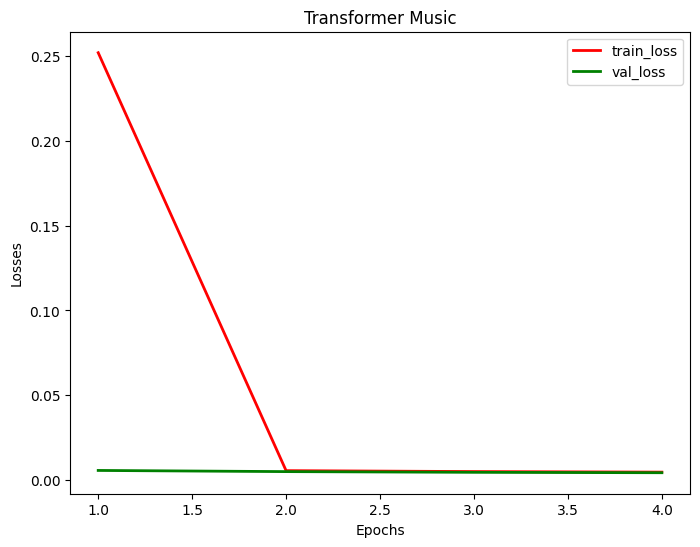

In [49]:

Display_Plot(train_loss=transformer_train_losses, valid_loss=transformer_valid_losses, model_name="Transformer Music")

In [50]:
torch.save(model.state_dict(), "music_transformer_model.pth")

In [51]:
# this just grabs a random batch and performs on it
for batch in validation_dataloader:
    bleh = generate_music(model, batch[2][:window_length], temperature=1.0)
    notes = [token_to_note[token] for token in bleh]
    print(print(notes[window_length:]))
    break

/tmp/ipykernel_6905/1708115621.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_tokens = torch.tensor(start_tokens).clone().detach().unsqueeze(0) # (1, len(start_tokens))


['noteG#3', '1/4', 'noteC3', '1/4', 'noteC#2', '1/2', 'noteC2', '1/2', 'noteC3', '1/2', 'noteE2', '1/2', 'noteE3', '1/2', 'noteG#3', '1/2', 'rest', '3', 'noteC2', '1/2', 'noteF2', '1/2', 'noteC3', '1/2', 'noteC#3', '1/2', 'noteF3', '1/2', 'noteG#2', '1/2', 'noteB-1', '1/2', 'noteB-2', '1/2', 'noteF2', '1/2', 'noteG#2', '1/2', 'noteC#3', '1/2', 'noteF3', '1/2', 'noteG#3', '1/2', 'noteF#1', '1/2', 'noteF#2', '1/2', 'noteF#2', '1/2', 'noteA2', '1/2', 'noteF1', '1/2', 'noteC2', '1/2', 'noteF2', '1/2', 'noteF2', '1/2', 'noteB-2', '1/2', 'noteF#2', '1/2', 'noteF#2', '1/2', 'noteA2', '1/2', 'noteA2', '1/2', 'noteF1', '1/2', 'noteF1', '1/2', 'noteF2', '1/2', 'noteF2', '1/2', 'noteC2', '1/2', 'noteF#2', '1/2', 'noteF#2', '1/2', 'noteA2', '1/2', 'noteC3', '1/2', 'noteF1', '1/2', 'noteF1', '1/2', 'noteF2', '1/2', 'noteF2', '1/2', 'noteF#2', '1/2', 'noteF#2', '1/2', 'noteF#2', '1/2', 'noteA2', '1/2', 'noteF1', '1/2', 'noteF1', '1/2', 'noteF2', '1/2', 'noteA1', '1/2', 'noteF#2', '1/2', 'noteF#2', '

In [52]:
with open("music.txt", "w") as file:
    for item in notes[window_length:]:
        file.write(item + "\n")